In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

BASE_DIR     = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
SUBDIRS      = ["1-4", "1-5", "1-6", "1-7"]
PROFILES_CSV = "thermocline_profiles.csv"
HISTORY_CSV  = "thermocline_timehistory.csv"
SUMMARY_CSV  = "geometry_summary.csv"
BASE_TIME    = datetime(2033, 3, 20, 11, 0, 0)

studies = {}
for sub in SUBDIRS:
    path = os.path.join(BASE_DIR, sub)
    # load profiles
    sim_df = pd.read_csv(os.path.join(path, PROFILES_CSV))
    # load history
    time_df = pd.read_csv(os.path.join(path, HISTORY_CSV))
    time_df = time_df[time_df["time_sec"] > 0].copy()
    time_df["time_dt"] = time_df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )
    # load summary
    summary_df = pd.read_csv(os.path.join(path, SUMMARY_CSV))
    # store
    studies[sub] = {
        "sim":     sim_df,
        "time":    time_df,
        "summary": summary_df
    }

# ── Thermocline plots ────────────────────────────────────────────
for name, data in studies.items():
    sim_df  = data["sim"]
    time_df = data["time"]

    # FIGURE 1: T vs Radius
    plt.figure(figsize=(6,4))
    for phase in sorted(sim_df["Phase"].unique()):
        dfp = sim_df[sim_df["Phase"] == phase]
        plt.plot(
            dfp["Radius_m"],
            dfp["Temperature_C"],
            ":",
            lw=2,
            color=dfp["Line_Color"].iloc[0]
        )
    plt.title(f"{name} – Temperature vs Radius")
    plt.xlabel("Radius (m)")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

    # FIGURE 2: dT/dr vs Radius
    plt.figure(figsize=(6,4))
    for phase in sorted(sim_df["Phase"].unique()):
        dfp = sim_df[sim_df["Phase"] == phase]
        slope = np.gradient(dfp["Temperature_C"], dfp["Radius_m"])
        plt.plot(
            dfp["Radius_m"],
            slope,
            ":",
            lw=2,
            color=dfp["Line_Color"].iloc[0]
        )
    plt.title(f"{name} – Temperature Gradient vs Radius")
    plt.xlabel("Radius (m)")
    plt.ylabel("dT/dr (°C/m)")
    plt.tight_layout()
    plt.show()

    # FIGURE 3: T vs Time
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    Ts_cols = [c for c in time_df.columns if c.startswith("Ts_r")]
    for col in Ts_cols:
        trace = time_df[col] - 273.15
        valid = (trace > -50) & np.isfinite(trace)
        ax.plot(time_df["time_dt"][valid], trace[valid])
    plt.title(f"{name} - Temperature vs Time")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

# ── Bar plots comparison ────────────────────────────────────────────
all_summaries = []
for name, data in studies.items():
    df = data["summary"].copy()
    df["Geometry"] = name
    all_summaries.append(df)
all_summary_df = pd.concat(all_summaries, ignore_index=True)

x     = np.arange(len(all_summary_df))
width = 0.15

fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x - 2*width, all_summary_df["AvgDeltaP_Pa"],        width, label="ΔP (Pa)")
ax.bar(x -    width, all_summary_df["Max Pumping Power [kW]"], width, label="Peak Pump (kW)")
ax.bar(x,        all_summary_df["Pump_Energy_kWh"],      width, label="Pump Energy (kWh)")
# ax.bar(x +    width, all_summary_df["Charge_ex_kWh"],      width, label="Charge Exergy (kWh)")
# ax.bar(x + 2*width, all_summary_df["Discharge_ex_kWh"],     width, label="Discharge Exergy (kWh)")
ax.bar(x + 3*width, all_summary_df["Eta_exergy"],       width, label="Exergy Eff.")

ax.set_xticks(x)
ax.set_xticklabels(all_summary_df["Geometry"], rotation=0)
ax.set_ylabel("Value")
ax.set_title("Geometry Study Comparison")
ax.legend(ncols=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tljohn\\Desktop\\RPB Micmaq\\geometry simulations\\1-4\\thermocline_profiles.csv'

In [ ]:
# ── Thermocline‐front vs Hour ────────────────────────────────────────────
plt.figure(figsize=(8,5))
for name, data in studies.items():
    sim_df = data["sim"]
    # for each Phase (0,1,2,…), find the radius of max abs(dT/dr)
    phases = sorted(sim_df["Phase"].unique())
    front_r = []
    for p in phases:
        dfp = sim_df[sim_df["Phase"] == p]
        grad = np.abs(np.gradient(dfp["Temperature_C"], dfp["Radius_m"]))
        idx  = np.argmax(grad)
        front_r.append(dfp["Radius_m"].values[idx])
    hours = np.array(phases) + 1  # if phase 0→ hour1, phase1→ hr2, etc.
    plt.plot(hours, front_r, marker='o', label=name)

plt.xlabel("Hour")
plt.ylabel("Thermocline Front Radius (m)")
plt.title("Thermocline front Position vs. Time")
plt.grid(True)
plt.legend(title="Geometry", loc="best")
plt.tight_layout()
plt.show()


In [ ]:
df = all_summary_df.copy()  
 

# 2D projections:
fig, axes = plt.subplots(1,2, figsize=(10,4))

# Exergy vs Cost
axes[0].scatter(df["Insulation_Cost_$"], df["Exergy_kWh"], s=100)
for i,r in df.iterrows():
    axes[0].annotate(r["Geometry"], (r["Insulation_Cost_$"], r["Exergy_kWh"]))
axes[0].set_xlabel("Insulation Cost ($)")
axes[0].set_ylabel("Exergy Stored (kWh)")
axes[0].set_title("Exergy vs Cost")

# Exergy vs Pump Losses
axes[1].scatter(df["Pump_Energy_kWh"], df["Exergy_kWh"], s=100)
for i,r in df.iterrows():
    axes[1].annotate(r["Geometry"], (r["Pump_Energy_kWh"], r["Exergy_kWh"]))
axes[1].set_xlabel("Pump Losses (kWh)")
axes[1].set_ylabel("Exergy Stored (kWh)")
axes[1].set_title("Exergy vs Pump Loss")
plt.tight_layout()
plt.show()


KeyError: '1_5_1'

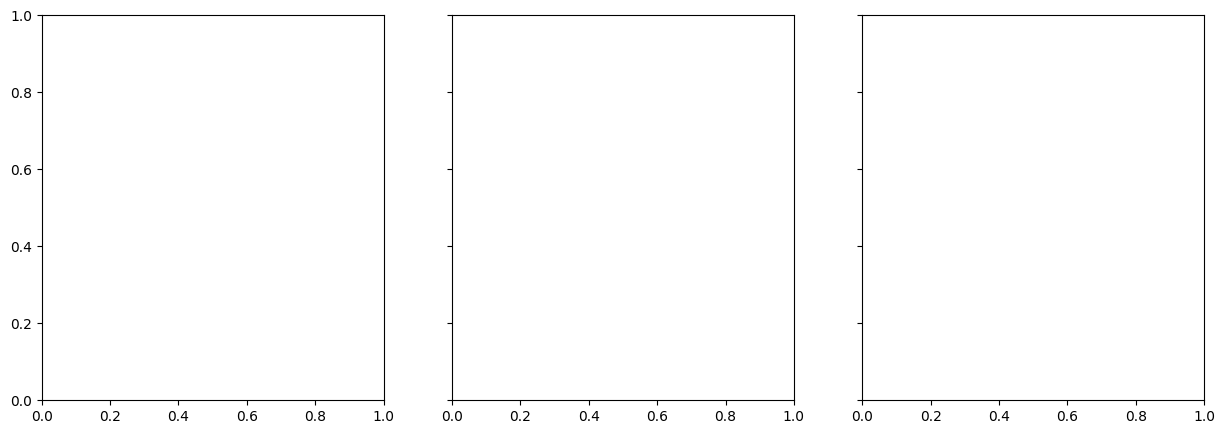

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
SUBDIRS = [
    "1_5_1",
    "1-1",
    "1-1_5",
    "1-2",
    "1-2_5",
    "1-3",
    "2_5-1",
    "2-1",
    "3-1",
]
PROFILES   = "thermocline_profiles.csv"

# Which hours (phases) to snapshot?
TRACE_HOURS = [1, 6, 8]
PHASE_IDX   = [h-1 for h in TRACE_HOURS]

# Assign one color per geometry
colors = {"1-4":"C0", "1-5":"C1", "1-6":"C2", "1-7":"C3"}

# Load each simulation's profiles
all_data = {}
for geo in SUBDIRS:
    fp = os.path.join(BASE_DIR, geo, PROFILES)
    all_data[geo] = pd.read_csv(fp)

# Build 1×3 plot of thermocline at the three hours
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for ax, hour, phase in zip(axs, TRACE_HOURS, PHASE_IDX):
    for geo, df in all_data.items():
        dfp = df[df["Phase"] == phase]
        ax.plot(
            dfp["Radius_m"],
            dfp["Temperature_C"],
            color=colors[geo],
            lw=2,
            label=geo
        )
    ax.set_title(f"Hour {hour}")
    ax.set_xlabel("Radius (m)")

axs[0].set_ylabel("Temperature (°C)")
axs[-1].legend(title="Geometry (H:R)", loc="upper right", bbox_to_anchor=(1.3,1))

plt.tight_layout()
plt.show()


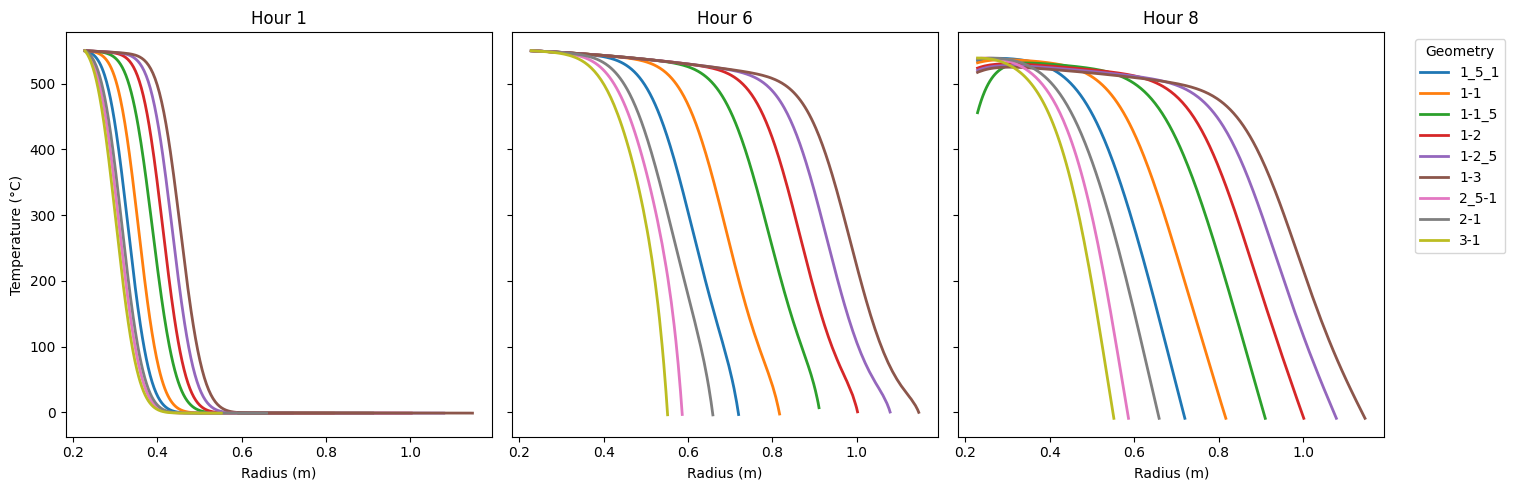

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
PROFILES   = "thermocline_profiles.csv"

#——— manually list exactly the geometries you have ———
SUBDIRS = [
    "1_5_1",
    "1-1",
    "1-1_5",
    "1-2",
    "1-2_5",
    "1-3",
    "2_5-1",
    "2-1",
    "3-1",
]

# which hours/phases to snapshot?
TRACE_HOURS = [1, 6, 8]
PHASE_IDX   = [h-1 for h in TRACE_HOURS]

# pick a distinct color for each
palette = plt.get_cmap("tab10")
colors  = {geo: palette(i%10) for i, geo in enumerate(SUBDIRS)}

# load all CSVs
all_data = {}
for geo in SUBDIRS:
    path = os.path.join(BASE_DIR, geo, PROFILES)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {PROFILES} in folder {geo}")
    all_data[geo] = pd.read_csv(path)

# build 1×3 panel
fig, axs = plt.subplots(1, len(TRACE_HOURS), figsize=(5*len(TRACE_HOURS),5), sharey=True)

for ax, hour, phase in zip(axs, TRACE_HOURS, PHASE_IDX):
    for geo, df in all_data.items():
        dfp = df[df["Phase"] == phase]
        ax.plot(dfp["Radius_m"], dfp["Temperature_C"],
                color=colors[geo], lw=2, label=geo)
    ax.set_title(f"Hour {hour}")
    ax.set_xlabel("Radius (m)")

axs[0].set_ylabel("Temperature (°C)")
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout()
plt.show()
